<a href="https://colab.research.google.com/github/kerndre/CCU-Forcasting/blob/main/2_BaselineModel/baseline_advanced_time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
---
---
#Setup


## Imports

In [46]:
# Import necessary libraries from Google Colab
from google.colab import drive
from google.colab import userdata
import os  # Provides a way of using operating system dependent functionality

# Libraries for handling data formats and compression
import json  # Library for parsing JSON (JavaScript Object Notation) data

# Libraries for data manipulation and numerical operations
import numpy as np  # Library for numerical operations
import pandas as pd  # Library for data manipulation and analysis


# Library for plotting graphs
import matplotlib.pyplot as plt

# Libraries for machine learning models and data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score  # Performance metrics

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')  # Ignore warnings


## Connecting to Drive

In [47]:
# data path
data_path = '/content/drive/MyDrive/'

In [48]:
# Flushes the mounts, ensuring that all changes are written and the drive is safely unmounted
drive.flush_and_unmount()

# Mount the Google Drive to the specified path
drive.mount('/content/drive')

# Change the current working directory to the specified data path
os.chdir(data_path)

Mounted at /content/drive


## Functions

In [50]:
# Function to create a DataFrame for model evaluation metrics
def create_evaluation_df(model_name, target, features, mse, mae, r2, explained_variance):
    # Create a dictionary with the evaluation metrics
    data = {
        'modelname': [model_name],             # Model name
        'target': [target],                    # Target variable
        'features': [features],                # List of features used
        'mse': [mse],                          # Mean Squared Error
        'mae': [mae],                          # Mean Absolute Error
        'r2': [r2],                            # R-squared value
        'explained_variance': [explained_variance]  # Explained Variance Score
    }

    # Convert the dictionary to a pandas DataFrame
    evaluation_df = pd.DataFrame(data)
    # Return the DataFrame
    return evaluation_df


---
---
# **Baseline Model**

---
## Loading

In [51]:
# Set the loading version number
LOADING_VERSIONSNUMMER = 'v1.1'

# Retrieve the path to the project data using userdata
LOADING_PATH = userdata.get('ts_project_data_path')

# Define the name of the DataFrame file to be loaded
LOADING_DF_NAME = f'df_ts_ccu_{LOADING_VERSIONSNUMMER}'

# Define the name of the JSON file that contains the data types of the DataFrame
LOADING_DTYPES_DF_NAME = 'dtypes_' + LOADING_DF_NAME


In [52]:
# Load the dtypes (data types) from a JSON file

# Construct the full path to the JSON file containing the dtypes
dtypes_file_path = LOADING_PATH + '/' + LOADING_DTYPES_DF_NAME + '.json'

# Open the JSON file in read mode
with open(dtypes_file_path, 'r') as f:
    # Load the JSON content into a dictionary
    dtypes = json.load(f)


In [53]:
# Load the DataFrame from a CSV file
df_sl = pd.read_csv(
    LOADING_PATH + '/' + LOADING_DF_NAME + '.csv',  # Construct the full path to the CSV file
    dtype=dtypes,                                  # Specify the data types for each column
    parse_dates=['timestamp']                      # Tell pandas to parse the 'timestamp' column as dates
)


---

In [54]:
# set timestamp as index
df_sl.set_index('timestamp', inplace=True)

In [55]:
# shape of df
df_sl.shape

(5270376, 3)

In [56]:
# head of df
df_sl.head().style

,abs_ended_sessions,mean_duration_end,concurrent_sessions
timestamp,,,
2024-03-01 00:00:12,0,0,603
2024-03-01 00:00:13,0,0,603
2024-03-01 00:00:14,0,0,603
2024-03-01 00:00:15,0,0,603
2024-03-01 00:00:16,0,0,603


In [57]:
# first and last date
df_sl.index.min(), df_sl.index.max()

(Timestamp('2024-03-01 00:00:12'), Timestamp('2024-04-30 23:59:59'))

In [58]:
df_sl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5270376 entries, 2024-03-01 00:00:12 to 2024-04-30 23:59:59
Data columns (total 3 columns):
 #   Column               Dtype 
---  ------               ----- 
 0   abs_ended_sessions   int64 
 1   mean_duration_end    object
 2   concurrent_sessions  int64 
dtypes: int64(2), object(1)
memory usage: 160.8+ MB


In [59]:
# checking nan values
df_sl.isna().sum()

abs_ended_sessions     0
mean_duration_end      0
concurrent_sessions    0
dtype: int64

---
## Feature Engineering

In [60]:
# copy df_sl
df_ts = df_sl.copy()

In [61]:
# Shift the 'concurrent_sessions' column by 7 days to create a new column 'concurrent_sessions_7D'
# This represents the number of concurrent sessions exactly 7 days prior to the current timestamp
df_ts['concurrent_sessions_7D'] = df_ts.concurrent_sessions.shift(7, freq='D')

In [62]:
df_ts.head().style

,abs_ended_sessions,mean_duration_end,concurrent_sessions,concurrent_sessions_7D
timestamp,,,,
2024-03-01 00:00:12,0,0,603,nan
2024-03-01 00:00:13,0,0,603,nan
2024-03-01 00:00:14,0,0,603,nan
2024-03-01 00:00:15,0,0,603,nan
2024-03-01 00:00:16,0,0,603,nan


In [63]:
# compare concurrent sessions with the 7 days lagged values
df_ts[['concurrent_sessions', 'concurrent_sessions_7D']]

,concurrent_sessions,concurrent_sessions_7D
timestamp,,
2024-03-01 00:00:12,603,NaN
2024-03-01 00:00:13,603,NaN
2024-03-01 00:00:14,603,NaN
2024-03-01 00:00:15,603,NaN
2024-03-01 00:00:16,603,NaN
...,...,...
2024-04-30 23:59:55,939,936.0
2024-04-30 23:59:56,939,936.0
2024-04-30 23:59:57,939,936.0


In the head of the df can be seen that therea a NaN values for `concurrent_sessions_7D`. This is because the lagged values are taken from a previous week, and the first week in this data frame has no previous week.

In the tail of the df can be seen that the lagged values are very near to the actual numbers of sessions.

In [64]:
# drop NAs which that arose when creating the lagged values
# Means that the first week of data is omitted as there is no data from a previous week
df_tsa = df_ts.dropna()

In [65]:
df_tsa.isna().sum()

abs_ended_sessions        0
mean_duration_end         0
concurrent_sessions       0
concurrent_sessions_7D    0
dtype: int64

---
---
## **Model**

For the baseline model, I tested the significance of the seven-day lagged values for predicting the concurrent sessions of coming weeks. This seems reasonable due to the daily and weekly repeating pattern of the data.

This approach has the results that there is no training and test data, only shifted_data which would be X_test and y_test.

### Feature Selection

In [66]:
# Create X and y objects
X = df_tsa['concurrent_sessions_7D']
y = df_tsa['concurrent_sessions']

### Model Implementation

In [67]:
# Create Train test split
_, shifted_data, _, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)

In [68]:
shifted_data

timestamp
2024-04-17 12:00:09    1796.0
2024-04-17 12:00:10    1796.0
2024-04-17 12:00:11    1796.0
2024-04-17 12:00:12    1796.0
2024-04-17 12:00:13    1796.0
                        ...  
2024-04-30 23:59:55     936.0
2024-04-30 23:59:56     936.0
2024-04-30 23:59:57     936.0
2024-04-30 23:59:58     937.0
2024-04-30 23:59:59     937.0
Name: concurrent_sessions_7D, Length: 1166391, dtype: float64

In [69]:
y_test

timestamp
2024-04-17 12:00:09    1799
2024-04-17 12:00:10    1800
2024-04-17 12:00:11    1800
2024-04-17 12:00:12    1800
2024-04-17 12:00:13    1799
                       ... 
2024-04-30 23:59:55     939
2024-04-30 23:59:56     939
2024-04-30 23:59:57     939
2024-04-30 23:59:58     939
2024-04-30 23:59:59     939
Name: concurrent_sessions, Length: 1166391, dtype: int64

### Evaluation

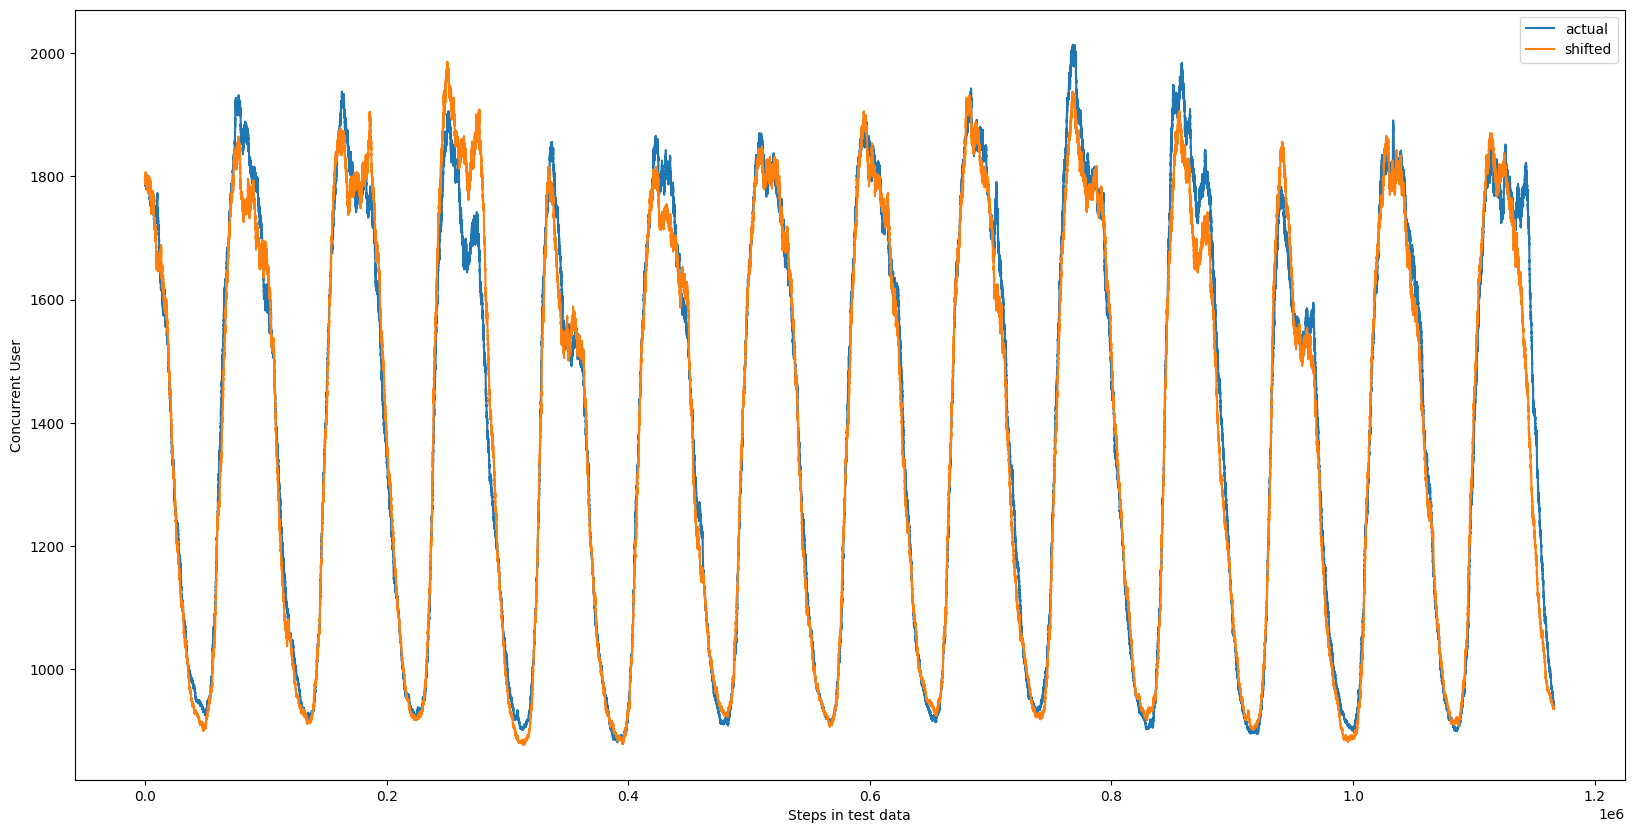

In [70]:
# Create a new figure with a specified size
plt.figure(figsize=(20, 10))

# Plot the actual test data values
plt.plot(list(y_test))

# Plot the shifted data values
plt.plot(list(shifted_data))

# Add a legend to the plot for clarity
plt.legend(['actual', 'shifted'])

# Label the y-axis
plt.ylabel('Concurrent User')

# Label the x-axis
plt.xlabel('Steps in test data')

# Display the plot
plt.show()

The lagged values already match the test data very well. On some days the values are slightly shifted in the upward/downward trend, and the peak values of the days look slightly different on most days. But the overall ccu numbers already match pretty well.

In [71]:
# Calculate various performance metrics for the model
mse = mean_squared_error(y_test, shifted_data)  # Mean Squared Error
mae = mean_absolute_error(y_test, shifted_data)  # Mean Absolute Error
r2 = r2_score(y_test, shifted_data)  # R-squared value
explained_variance = explained_variance_score(y_test, shifted_data)  # Explained Variance Score

In [72]:
# Define the model name and features used
model_name = "baseline_model"
features = "concurrent_sessions_7D"

# Get the target variable's name
target = y.name

# Create a DataFrame with the evaluation metrics for the baseline model
eval_baseline = create_evaluation_df(
    model_name=model_name,          # Name of the model
    target=target,                  # Target variable name
    features=features,              # Features used in the model
    mse=mse,                        # Mean Squared Error
    mae=mae,                        # Mean Absolute Error
    r2=r2,                          # R-squared value
    explained_variance=explained_variance  # Explained Variance Score
)

In [73]:
eval_baseline.style

,modelname,target,features,mse,mae,r2,explained_variance
0,baseline_model,concurrent_sessions,concurrent_sessions_7D,3099.132959,37.412436,0.975018,0.975988


**Model Name: `baseline_model`**

**Target: `concurrent_sessions`**
- The target variable that the model aims to predict is the number of concurrent sessions.

**Features: `concurrent_sessions_7D`**
- The feature used by the model is the concurrent session data from the past seven days.

**Metrics**
- **Mean Squared Error (MSE): `3099.132959`**
    - MSE measures the average of the squares of the errors—that is, the average squared difference between the actual and predicted values.
    - An MSE of 3099.13 indicates that, on average, the squared difference between the predicted and actual concurrent sessions is 3099.13. This value is used to assess the overall accuracy of the model, with lower values indicating better performance.

- **Mean Absolute Error (MAE): `37.412436`**
    - MAE measures the average absolute difference between the actual and predicted values.
    - An MAE of 37.41 means that, on average, the model’s predictions are off by about 37.41 sessions. This metric provides a straightforward interpretation of prediction accuracy, with lower values indicating better performance.

- **R-Squared (R²): `0.975018`**
    - R² measures the proportion of the variance in the dependent variable that is predictable from the independent variable(s).
    - An R² value of 0.975018 indicates that approximately 97.5% of the variance in the number of concurrent sessions can be explained by the model. This is a high value, suggesting that the model fits the data very well.

- **Explained Variance: `0.975988`**
    - Explained variance is similar to R², indicating the proportion of the total variance in the target that is captured by the model.
    - An explained variance of 0.975988 means that the model accounts for about 97.6% of the variance in concurrent sessions, which further confirms the model's strong predictive power.

---
---
---